In [2]:
# importing the required libraries
library(keras)
library(grid)
library(abind)

In [3]:
# loading the data
data <- dataset_mnist()

In [4]:
# loading the training and test partitions of input data
x_train <- data$train$x
x_test <- data$test$x

In [5]:
# normalizing the data with the range of 0 and 1
x_train_norm <- x_train/255
x_test_norm <- x_test/255

In [6]:
x_train_norm <- array_reshape(x_train_norm,dim = c(60000,28,28,1))
x_test_norm <- array_reshape(x_test_norm,dim = c(10000,28,28,1))

In [7]:
# checking dimensions of normalized data
dim(x_train_norm)
dim(x_test_norm)

[1] 60000    28    28     1

[1] 10000    28    28     1

In [9]:
# visualizing sample image
options(repr.plot.width = 0.5,repr.plot.height = 1)

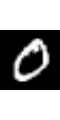

In [10]:
library(grid)
grid.raster(x_train_norm[2,,,])

In [11]:
# adding a normal random noise centered at 0.5 and std=0.5 to the input data 
noise_train <- array(data = rnorm(seq(0, 1, by = 0.02),mean = 0.5,sd = 0.5) ,dim = c(n_train,28,28,1))
dim(noise_train)
noise_test <- array(data = rnorm(seq(0, 1, by = 0.02),mean = 0.5,sd = 0.5) ,dim = c(n_test,28,28,1))
dim(noise_test)

[1] 60000    28    28     1

[1] 10000    28    28     1

In [12]:
x_train_norm_noise <- x_train_norm + noise_train
x_test_norm_noise <- x_test_norm + noise_test

In [13]:
# clipping the corrupted input data(input data + noise) for maintaining the pixel values in the range of 0 and 1
x_train_norm_noise[x_train_norm_noise < 0] <- 0 
x_train_norm_noise[x_train_norm_noise > 1] <- 1
x_test_norm_noise[x_test_norm_noise < 0] <- 0 
x_test_norm_noise[x_test_norm_noise > 1] <- 1

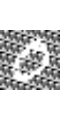

In [14]:
# visualizing a sample image
grid.raster(x_train_norm_noise[2,,,])

In [15]:
# creating the encoder part

# input layer
inputs <- layer_input(shape = c(28, 28, 1))
x = inputs

In [16]:
# configuring the layers for the encoder model
x <- x %>%
  layer_conv_2d(filter = 32, kernel_size = 3,padding = "same", input_shape = c(28, 28, 1)) %>%
  layer_activation("relu") %>%
  layer_conv_2d(filter = 64, kernel_size = 3) %>%
  layer_activation("relu")

In [17]:
# extracting the shape of the output tensor from the encoder network 
shape = k_int_shape(x)
shape

[[1]]
NULL

[[2]]
[1] 26

[[3]]
[1] 26

[[4]]
[1] 64

In [18]:
# adding a flattened layer and a dense layer at the end of the encoder model
x = x %>% layer_flatten()
latent = x %>% layer_dense(16,name = "latent")

In [19]:
# instantiating the encoder model
encoder = keras_model(inputs, latent)

In [20]:
# summary of the encoder model
summary(encoder)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                (None, 28, 28, 1)               0           
________________________________________________________________________________
conv2d (Conv2D)                     (None, 28, 28, 32)              320         
________________________________________________________________________________
activation (Activation)             (None, 28, 28, 32)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 26, 26, 64)              18496       
________________________________________________________________________________
activation_1 (Activation)           (None, 26, 26, 64)              0           
________________________________________________________________________________
flatten (Flatten)           

In [21]:
# decoder part of the network; output of encoder is fed as input for the decoder part
latent_inputs = layer_input(shape=16, name='decoder_input')

x = latent_inputs %>% layer_dense(shape[[2]] * shape[[3]] * shape[[4]]) %>%
     layer_reshape(c(shape[[2]],shape[[3]], shape[[4]]))

In [22]:
# configuring the layers of the decoder part
x <- x %>%
  layer_conv_2d_transpose(
    filter = 64, kernel_size = 3, padding = "same", 
    input_shape = c(28, 28, 1)
  ) %>%
  layer_activation("relu") %>%
  # Second hidden layer
  layer_conv_2d_transpose(filter = 32, kernel_size =3) %>%
  layer_activation("relu")


x = x %>% layer_conv_2d_transpose(filters=1,
                    kernel_size= 3,
                    padding='same')


outputs = x %>% layer_activation('sigmoid', name='decoder_output')

In [23]:
# instantiating the decoder model and see its summary
decoder = keras_model(latent_inputs, outputs)
summary(decoder)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
decoder_input (InputLayer)          (None, 16)                      0           
________________________________________________________________________________
dense (Dense)                       (None, 43264)                   735488      
________________________________________________________________________________
reshape (Reshape)                   (None, 26, 26, 64)              0           
________________________________________________________________________________
conv2d_transpose (Conv2DTranspose)  (None, 26, 26, 64)              36928       
________________________________________________________________________________
activation_2 (Activation)           (None, 26, 26, 64)              0           
________________________________________________________________________________
conv2d_transpose_1 (Conv2DTr

In [24]:
# building the autoencoder model

autoencoder = keras_model(inputs, decoder(encoder(inputs)))
summary(autoencoder)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                (None, 28, 28, 1)               0           
________________________________________________________________________________
model (Model)                       (None, 16)                      711056      
________________________________________________________________________________
model_1 (Model)                     (None, 28, 28, 1)               791169      
Total params: 1,502,225
Trainable params: 1,502,225
Non-trainable params: 0
________________________________________________________________________________


In [25]:
# compiling the autoencoder model
autoencoder %>% compile(loss = 'mse',optimizer = 'adam')

In [26]:
# training the autoencoder model
autoencoder %>% fit(x_train_norm_noise,
                    x_train_norm,
                    validation_data=list(x_test_norm_noise, x_test_norm),
                    epochs=30,batch_size= 128
                    )

In [27]:
# saving model
save_model_hdf5(autoencoder,"autoencoder_denoising_r_1.h5")

In [29]:
# generating predictions for the test data
prediction <- autoencoder %>% predict(x_test_norm_noise)

In [30]:
# visualizing the reconstructed inputs after the predictions
options(repr.plot.width=10, repr.plot.height=1)

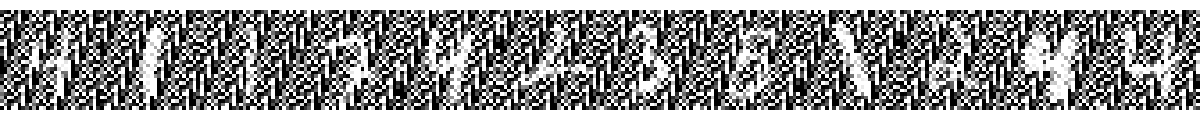

In [57]:
grid1 = x_test_norm_noise[20,,,]
for(i in seq(40,50)){
    grid1 = abind(grid1,x_test_norm_noise[i,,,],along = 2)
}

grid.raster(grid1,interpolate=FALSE)

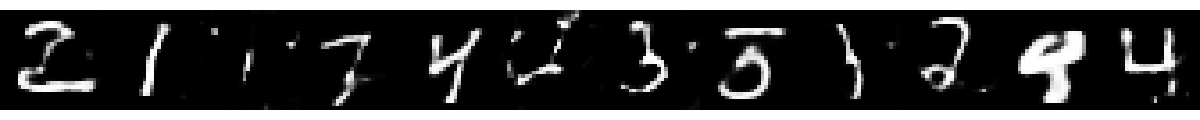

In [54]:
grid2 = prediction[2,,,]
for(i in seq(40,50)){
    grid2 = abind(grid2,prediction[i,,,],along = 2)
}

grid.raster(grid2,interpolate=FALSE)